* Input: embeddings in `io/` directory.
* Output: graphs

In [1]:
import json
from pathlib import Path
from ast import literal_eval
from typing import Tuple, Union, List
import numpy as np
import pandas as pd

import stats
import sys
import msgpack
from zipfile import ZipFile, ZipInfo
from pprint import pprint

In [2]:
n = 30
d = 2
noise = "human"
# DIR = Path("io/2021-03-09/")
DIR = Path("io/2021-03-27/")
EMBEDDINGS = DIR / "embeddings.zip"
# X_TEST = "NEXT"
X_TEST = "truth"

In [3]:
# EM_DIR = DIR / "embeddings"
SALMON_DIR = Path.home() / "Developer" / "stsievert" / "salmon"
sys.path.append(str(SALMON_DIR / "examples"))

In [4]:
def _get_config(name):
    return _get_dict(
        name.replace(".msgpack", "")
        .replace(".csv", "")
        .replace("responses*", "")
    )

from functools import lru_cache
@lru_cache()
def _read_csv(f: Path) -> pd.DataFrame:
    return pd.read_csv(f)
    
def _get(file: Union[Path, bytes], history=False, name=None) -> Union[Tuple[np.ndarray, dict], List[dict]]:
    if isinstance(file, (Path, str)):
        with open(file, "rb") as f:
            data = msgpack.load(f)
    else:
        data = msgpack.loads(file)
    em = data.pop("embedding")
    meta = data.pop("meta")
    perf = data.pop("performance")
    if history:
        return data["history"]
    for k, v in perf.items():
        meta[f"perf__{k}"] = v
    
    fname = meta.get("fname", "RandomSampling-5") or "RandomSampling-5"
    responses_per_sec = int(fname.split("_")[0].split("-")[-1])
    meta["responses_per_sec"] = str(responses_per_sec)
    if "RandomSampling" in fname:
        meta["responses_per_sec"] = "random"
#     print(responses_per_sec, meta["responses_per_sec"])
        
    return em, meta

In [5]:
data = []
with ZipFile(EMBEDDINGS, "r") as myzip:
    files = [f for f in myzip.filelist if ".msgpack" in f.filename]
    for k, f in enumerate(myzip.filelist):
        datum, em = _get(myzip.read(f), name=f.filename)
        data.append((datum, em))

In [6]:
from run import _X_test
import yaml
import zipfile

def _ground_truth(h, l, r):
    dl = np.abs(h - l)
    dr = np.abs(h - r)
    return "left" if dl < dr else "right"

with open(DIR / "config_RR-1.yaml", "r") as f:
    config = yaml.safe_load(f)

rare = [t.split("/")[-2] for t in config["targets"]]
mrare = [t.strip("i.png' ") for t in rare]
targets = [int(t) for t in mrare]

X_tests = {}
X_tests["next"] = _X_test()
N = range(30)
X_test = np.array([
    (hi, li, ri) if _ground_truth(h, l, r) == "left" else (hi, ri, li)
    for hi, h in enumerate(targets)
    for li, l in enumerate(targets)
    for ri, r in enumerate(targets)
    if h != l and h != r and r != l
])
X_tests["truth"] = X_test

In [7]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    perf = [{
        "measure": measure, **meta, **stats.collect(embedding, targets, X_test)
    } for embedding, meta in data for measure, X_test in X_tests.items()]
len(perf)

4488

In [8]:
import datasets

In [9]:
df = pd.DataFrame(perf)
df["n_responses/1000"] = df["n_responses"] / 1000
# list(sorted(df.columns))
df.columns.sort_values()

Index(['R', 'accuracy', 'alg', 'd', 'dataset', 'dist_rel_error',
       'embedding_error', 'embedding_rel_error', 'fname', 'ident', 'init',
       'kwargs__dwell', 'kwargs__max_epochs', 'kwargs__module__mu',
       'kwargs__random_state', 'kwargs__verbose', 'max_epochs', 'max_queries',
       'measure', 'n', 'n_responses', 'n_responses/1000', 'n_test', 'n_train',
       'nn_acc', 'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_10',
       'nn_acc_radius_11', 'nn_acc_radius_12', 'nn_acc_radius_13',
       'nn_acc_radius_14', 'nn_acc_radius_15', 'nn_acc_radius_16',
       'nn_acc_radius_17', 'nn_acc_radius_18', 'nn_acc_radius_19',
       'nn_acc_radius_2', 'nn_acc_radius_20', 'nn_acc_radius_21',
       'nn_acc_radius_22', 'nn_acc_radius_23', 'nn_acc_radius_24',
       'nn_acc_radius_25', 'nn_acc_radius_26', 'nn_acc_radius_27',
       'nn_acc_radius_28', 'nn_acc_radius_29', 'nn_acc_radius_3',
       'nn_acc_radius_4', 'nn_acc_radius_5', 'nn_acc_radius_6',
       'nn_acc_radius_7', 'n

In [10]:
uniqs = df.pivot_table(
    index="n_train",
    columns=["alg", "responses_per_sec"],
    values="kwargs__random_state",
    aggfunc="nunique",
)
assert uniqs["active"].nunique().all() == 1 and uniqs.to_numpy().flatten()[0] == 1
uniqs["random"].to_numpy().flatten()
# uniqs.to_numpy().flatten()

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., nan, 10.])

In [11]:
measure = "next"
show = df[df.measure == measure]

In [12]:
show.responses_per_sec.unique()

array(['50', '5', '1', '100', 'random', '20', '10', '2'], dtype=object)

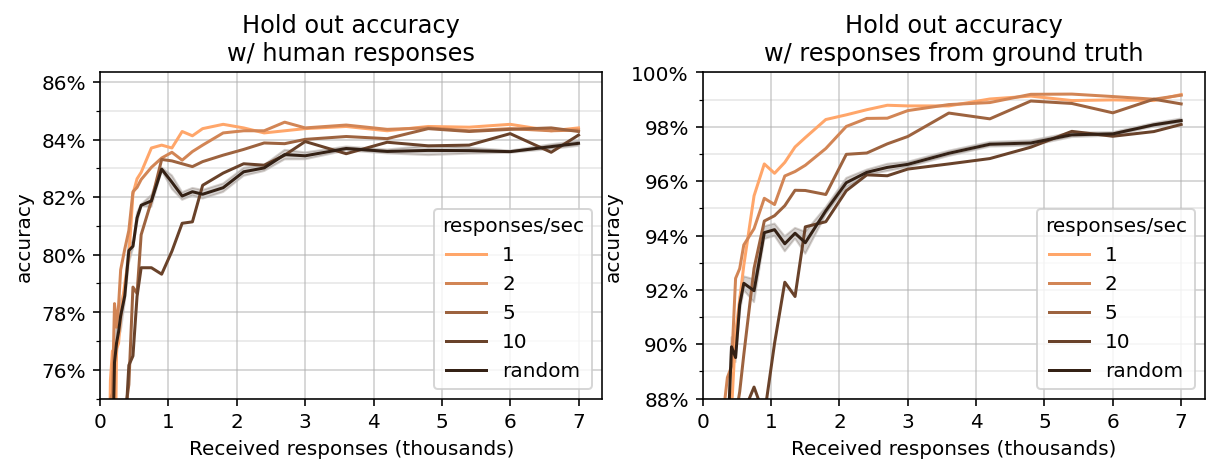

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 3.0
fig, axs = plt.subplots(ncols=2, figsize=(3.3 * w, w))

df["responses/sec"] = df["responses_per_sec"]
idx = (df.noise_model == "SOE")
kwargs = dict(
    x="n_responses/1000",
    y="accuracy",
    hue="responses/sec",
    hue_order=["1", "2", "5", "10", "random"],
    palette="copper_r",
    ci="sd",
)
ax = sns.lineplot(
    data=df[(df.measure == "next") & idx],
    ax=axs[0],
    **kwargs,
)
ax.set_ylim(0.75, None)
ax.set_title("Hold out accuracy\nw/ human responses")
ax = sns.lineplot(
    data=df[(df.measure == "truth") & idx],
    ax=axs[1],
    **kwargs,
)
ax.set_ylim(0.88, 1)
ax.set_title("Hold out accuracy\nw/ responses from ground truth")

for ax in axs:
    ax.grid(alpha=0.6)
    ax.grid(alpha=0.3, which="minor")
    ax.set_xlim(0, None)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
    ax.yaxis.set_minor_locator(plt.FixedLocator([0.01 + 2*x/100 for x in range(0, 100)]))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_xlabel("Received responses (thousands)")
fig.savefig("figs/accuracy.png", dpi=300, bbox_inches="tight")

In [14]:
df.columns

Index(['measure', 'n', 'd', 'R', 'dataset', 'random_state', 'reaction_time',
       'init', 'max_queries', 'fname', 'ident', 'kwargs__dwell',
       'kwargs__verbose', 'kwargs__random_state', 'kwargs__max_epochs',
       'n_train', 'n_test', 'n_responses', 'noise_model', 'threads', 'alg',
       'max_epochs', 'perf__pf_calls', 'perf__num_answers',
       'perf__model_updates', 'perf__num_grad_comps', 'perf__answers_bytes',
       'perf__score_train', 'perf__loss_train', 'perf__k',
       'perf__elapsed_time', 'perf__train_data', 'perf__n', 'perf__d',
       'perf__max_epochs', 'perf__verbose', 'perf__ident', 'perf___epochs',
       'perf__last_score', 'perf__score_test', 'perf__loss_test',
       'perf___elapsed_time', 'responses_per_sec', 'accuracy',
       'nn_diff_median', 'nn_diff_mean', 'nn_acc', 'nn_diff_p99',
       'nn_diff_p98', 'nn_diff_p95', 'nn_diff_p90', 'nn_diff_p80',
       'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50', 'nn_diff_p40',
       'nn_diff_p30', 'nn_diff_p20', '

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Accuracy on NEXT test dataset'}, xlabel='Num. responses (thousands)', ylabel='accuracy'>,
        <AxesSubplot:title={'center':'Number of items closer\nthan nearest neighbor (NN)'}, xlabel='Num. responses (thousands)', ylabel='Avg. number of items'>],
       dtype=object))

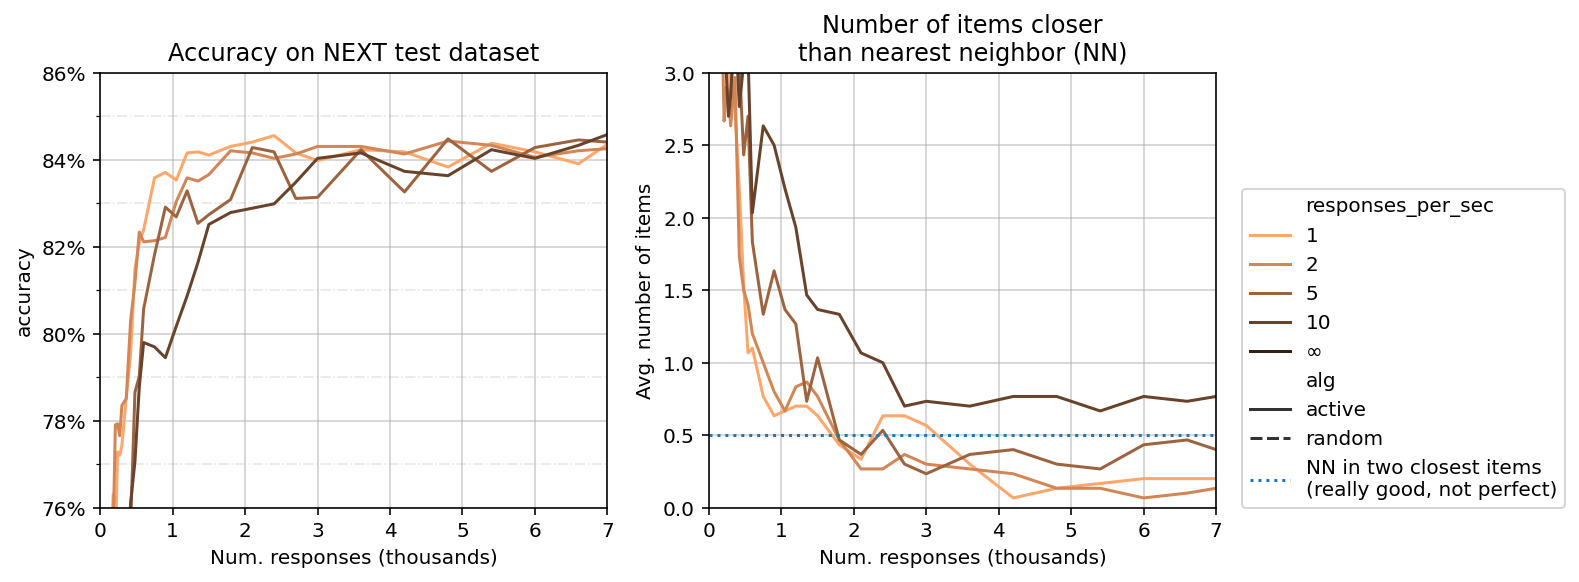

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def _create_fig(df, axs, nm=None, acc_only=False):
    w = 3
    show = df
    if nm is not None:
        show = df[df.noise_model == nm]
    kwargs = dict(
        x="n_responses/1000",
        hue="responses_per_sec",
        hue_order=["1", "2", "5", "10", "∞"],#, "20", "50", "100"],
        palette="copper_r",
    #     palette="",
        style="alg",
        ci=None,
        style_order=["active", "random"],
        data=show,
    )
    est = "max" if nm is None else "median"
    ax = sns.lineplot(y="accuracy", estimator=est, ax=axs[0], **kwargs)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
    ax.set_ylim(0.76, 0.86)
#     ax.yaxis.set_major_locator(plt.FixedLocator([0.7, 0.72, 0.75, 0.77, 0.80, 0.82, 0.85]))
    _ = ax.legend_.remove()
    ax.set_title("Accuracy on NEXT test dataset")
    _ = ax.grid(alpha=0.3, which="minor", linestyle="-.")
    if acc_only:
        ax.legend(loc=(1.05, 0))
        for ax in axs:
            _ = ax.grid(alpha=0.6)
            _ = ax.set_xlabel("Num. responses (thousands)")
            _ = ax.set_xlim(0, 7)
        return ax

    est = "min" if nm is None else "mean"
    ax = sns.lineplot(y="nn_diff_mean", estimator=est, ax=axs[1], **kwargs)
    ax.set_ylim(0, 3)
    ax.set_title("Number of items closer\nthan nearest neighbor (NN)")
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: x + 1))
    ax.set_ylabel("Avg. number of items")
    ax.plot([0, 7], [0.5, 0.5], linestyle="dotted", color="C0", label="NN in two closest items\n(really good, not perfect)")

#     est = "max" if nm is None else "mean"
#     ax = sns.lineplot(y="nn_acc_radius_1", estimator=est, ax=axs[1], **kwargs)
#     ax.set_ylim(0.2, 1)
#     ax.set_title("True nearest neighbor in two closest items?")
#     ax.set_ylabel("Accuracy")
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))

    ax.legend(loc=(1.05, 0))
    for ax in axs:
        _ = ax.grid(alpha=0.6)
        _ = ax.set_xlabel("Num. responses (thousands)")
        _ = ax.set_xlim(0, 7)
    return fig, axs

w = 4
fig, axs = plt.subplots(figsize=(2.5 * w, w), ncols=2)
_create_fig(show[show.measure == measure], axs, nm="CKL")

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Accuracy on NEXT test dataset'}, xlabel='Num. responses (thousands)', ylabel='accuracy'>,
        <AxesSubplot:title={'center':'Number of items closer\nthan nearest neighbor (NN)'}, xlabel='Num. responses (thousands)', ylabel='Avg. number of items'>],
       dtype=object))

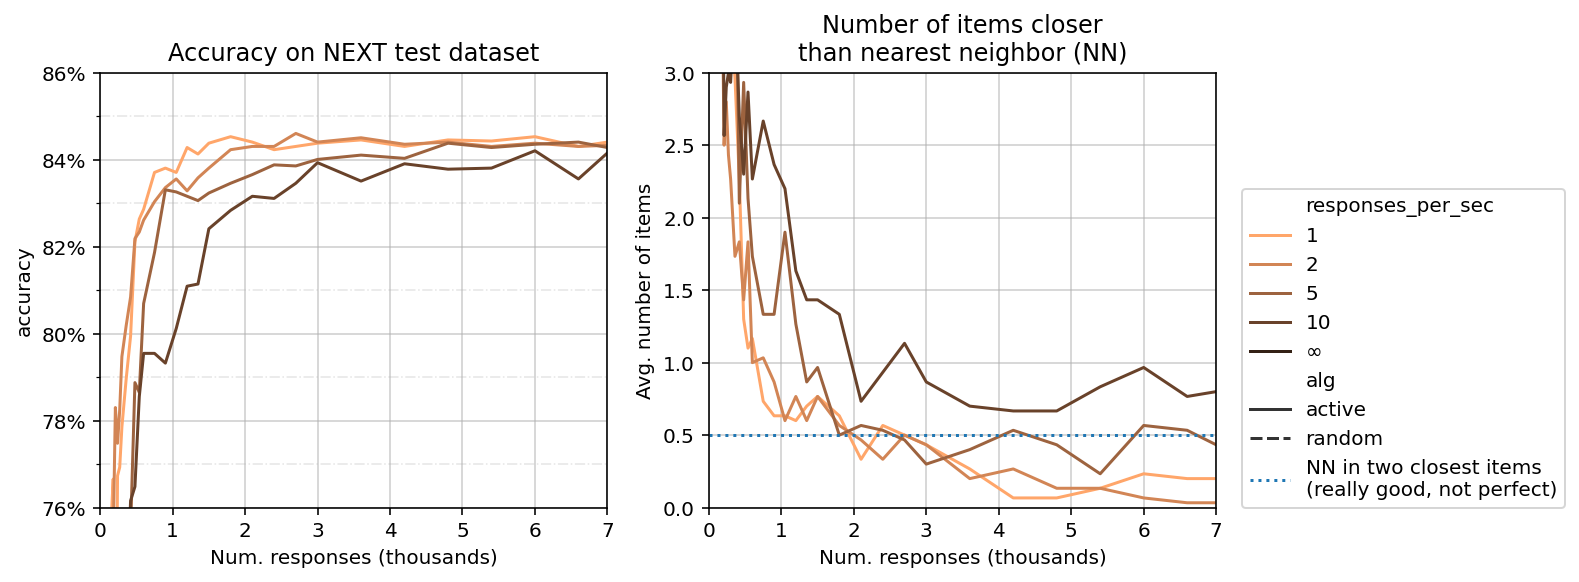

In [16]:
fig, axs = plt.subplots(figsize=(2.5 * w, w), ncols=2)
_create_fig(show, axs, nm="SOE")

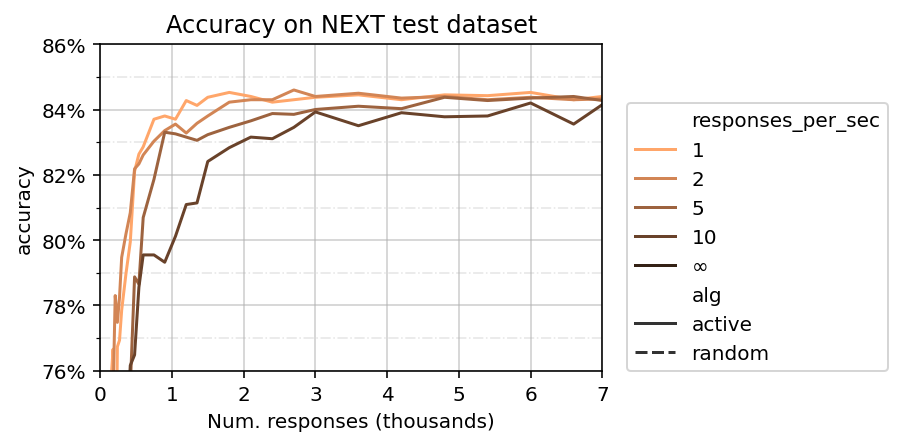

In [17]:
w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w), ncols=1)
ax = _create_fig(show, [ax], nm="SOE", acc_only=True)
fig.savefig(f"figs/{X_TEST}-SOE-acc.png", dpi=300, bbox_inches="tight")

(<Figure size 540x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Accuracy on NEXT test dataset'}, xlabel='Num. responses (thousands)', ylabel='accuracy'>,
        <AxesSubplot:title={'center':'Number of items closer\nthan nearest neighbor (NN)'}, xlabel='Num. responses (thousands)', ylabel='Avg. number of items'>],
       dtype=object))

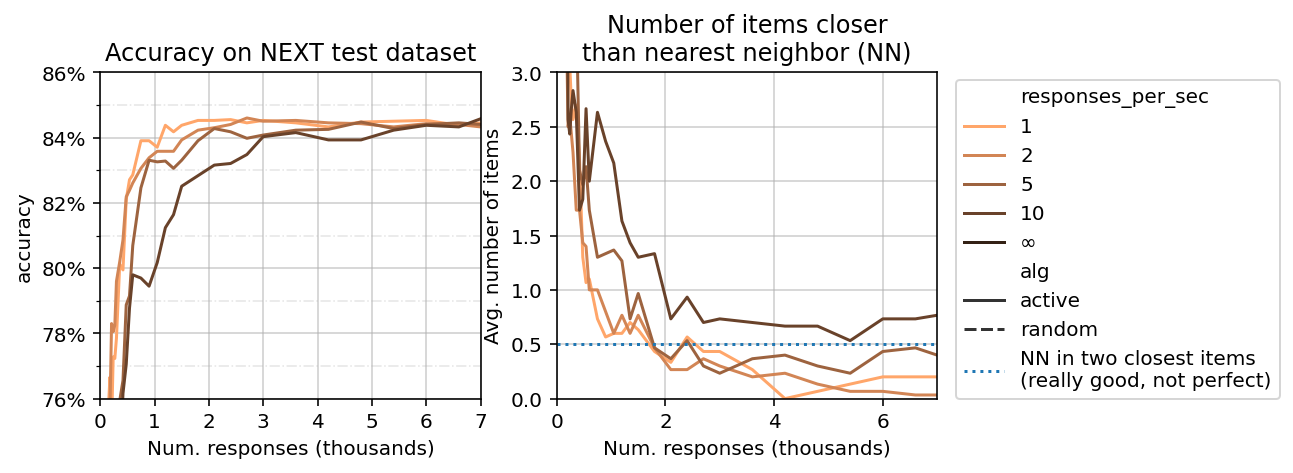

In [18]:
fig, axs = plt.subplots(figsize=(2.5 * w, w), ncols=2)
_create_fig(show, axs, nm=None)

(<Figure size 900x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Accuracy on NEXT test dataset'}, xlabel='Num. responses (thousands)', ylabel='accuracy'>,
        <AxesSubplot:title={'center':'Number of items closer\nthan nearest neighbor (NN)'}, xlabel='Num. responses (thousands)', ylabel='Avg. number of items'>],
       dtype=object))

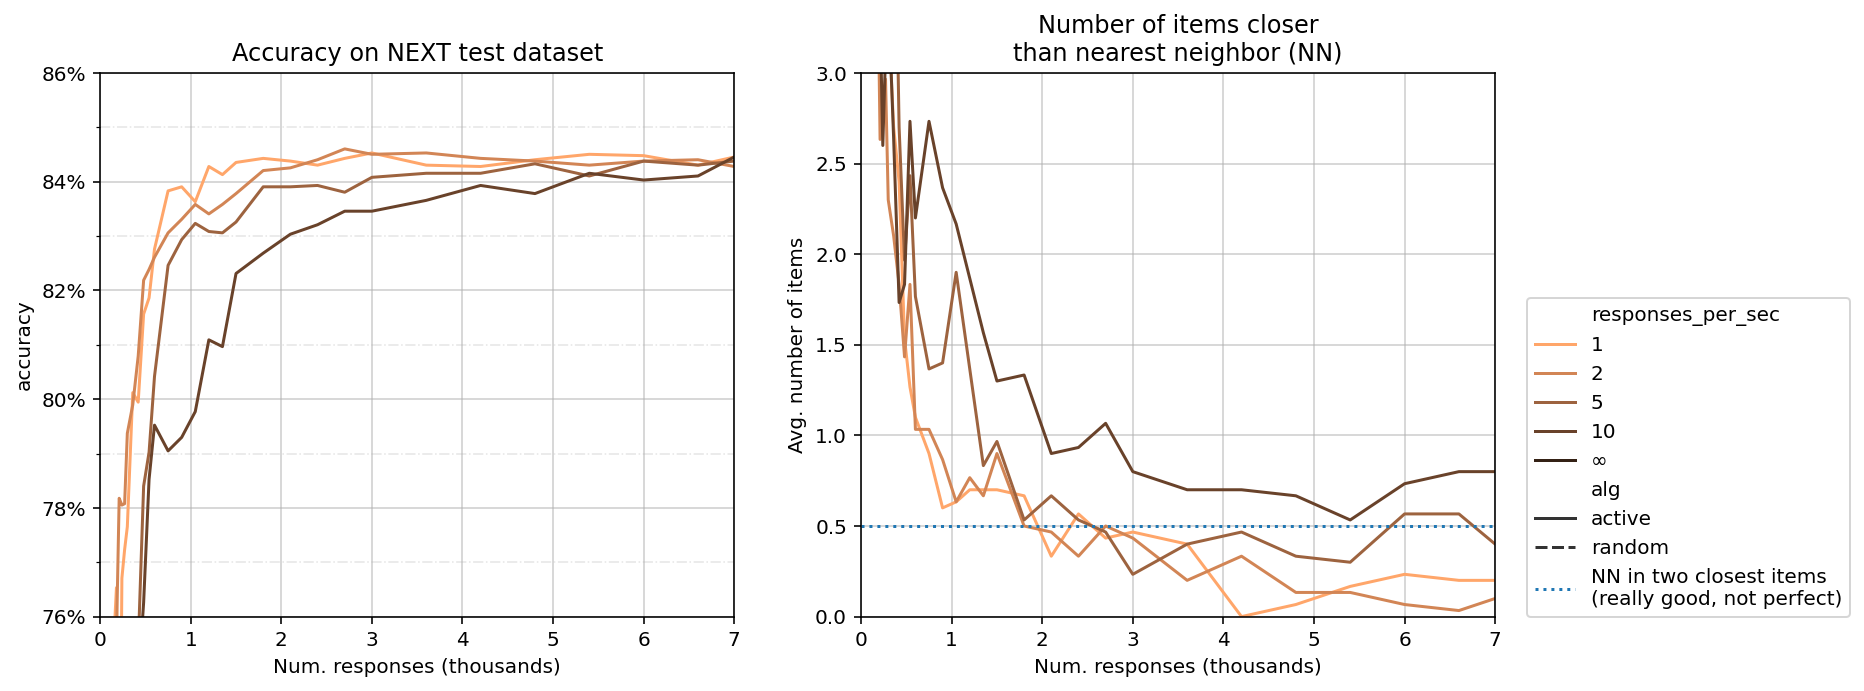

In [19]:
w = 5
fig, axs = plt.subplots(figsize=(2.5 * w, w), ncols=2)
_create_fig(show, axs, nm="TSTE")

(<Figure size 900x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Accuracy on NEXT test dataset'}, xlabel='Num. responses (thousands)', ylabel='accuracy'>,
        <AxesSubplot:title={'center':'Number of items closer\nthan nearest neighbor (NN)'}, xlabel='Num. responses (thousands)', ylabel='Avg. number of items'>],
       dtype=object))

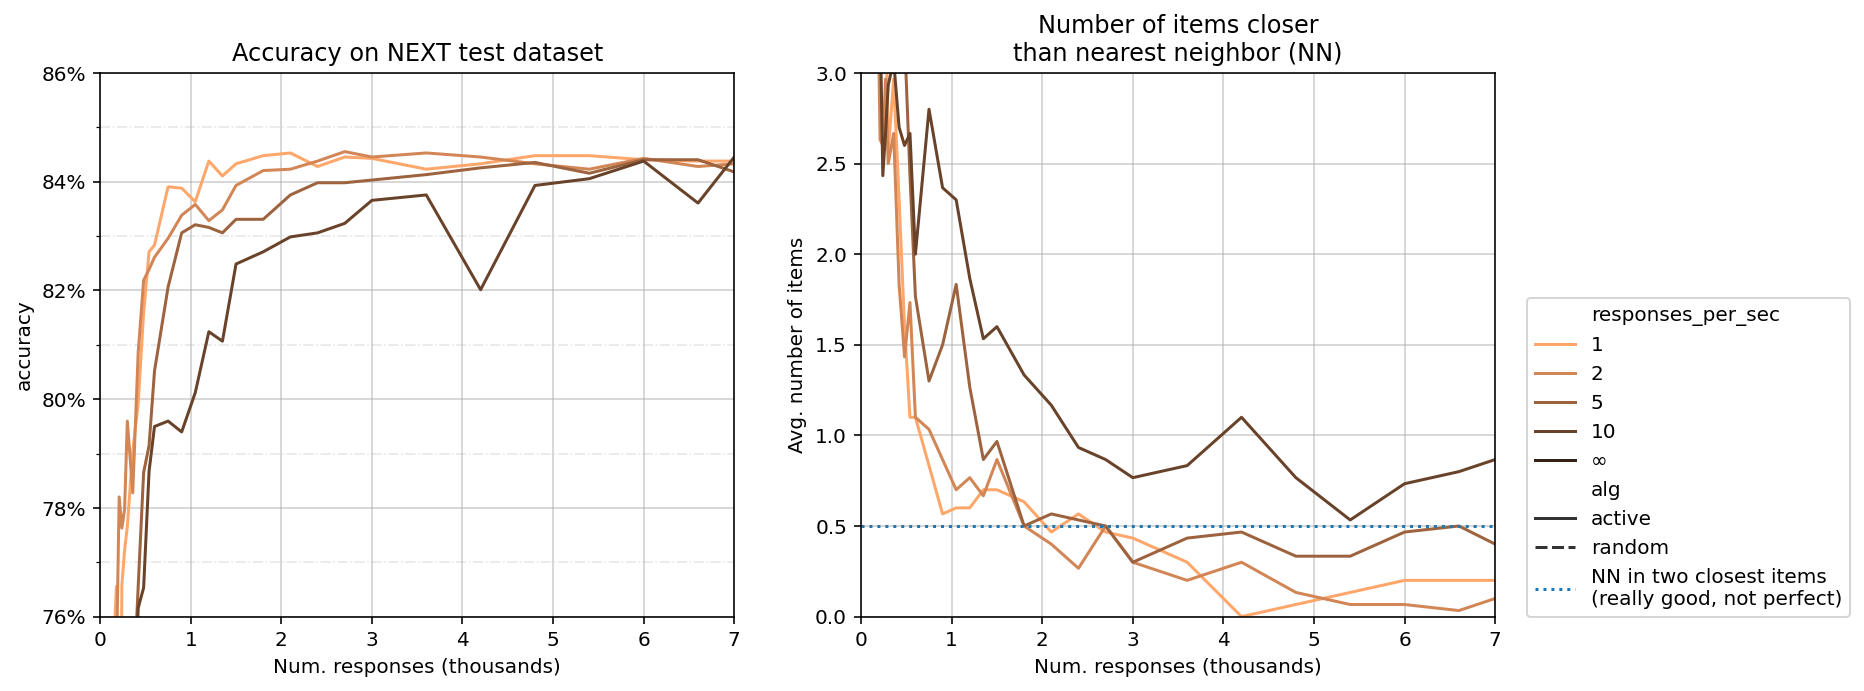

In [20]:
fig, axs = plt.subplots(figsize=(2.5 * w, w), ncols=2)
_create_fig(show, axs, nm="GNMDS")